In [2]:
import csv
from urllib.error import HTTPError, URLError
from urllib.request import urlopen
import pickle 
import pandas as pd
import numpy as np
import datetime

from bs4 import BeautifulSoup
from nltk import tokenize

from utils import pickle_load, pickle_dump 


In [22]:
base = "https://www.mountainproject.com/forum/103989405/general-climbing"
num_pages = 2

from scrape_forum import get_post_urls

forum_posts = get_post_urls(base, num_pages)
forum_posts

['https://www.mountainproject.com/forum/topic/125169949/why-does-mens-journal-even-try',
 'https://www.mountainproject.com/forum/topic/123913644/name-that-route-volume-viii',
 'https://www.mountainproject.com/forum/topic/124926580/new-and-experienced-climbers-over-50-26',
 'https://www.mountainproject.com/forum/topic/125178608/smith-rock-aac-narrow-miss',
 'https://www.mountainproject.com/forum/topic/125178552/death-on-mountaineers-route-on-whitney',
 'https://www.mountainproject.com/forum/topic/123740109/climbing-memes-60',
 'https://www.mountainproject.com/forum/topic/107347813/the-brotherhood-of-the-traveling-stopper',
 'https://www.mountainproject.com/forum/topic/125140211/puff-the-cat-historic-2nd-flat-iron-ascent-via-freeway',
 'https://www.mountainproject.com/forum/topic/125165886/if-you-tr-andor-dog-your-way-up-a-route-your-downgrade-suggestion-should-be-igno',
 'https://www.mountainproject.com/forum/topic/125168563/17',
 'https://www.mountainproject.com/forum/topic/123796595/b

### Concatenate temporary csv dump files

In [3]:
import scrape_forum
import importlib

In [4]:
from scrape_forum import load_and_concatenate_temp_data


files = ['9953', '14474', '69658', '50549', '29338']
base = 'data/temp/general-climbing'
df = load_and_concatenate_temp_data(base, files)

/home/tybens/Desktop/Senior/NLP IW/climbing-analysis/scrape_forum.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date[['days' in i for i in df.date.values]] = pd.to_numeric(days_ago.str[0]).apply(subtract_days_from_current)
/home/tybens/Desktop/Senior/NLP IW/climbing-analysis/scrape_forum.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date[df.date.str.contains('hours')] = [datetime.date.today().strftime("%b %d, %Y") for _ in df.date[df.date.str.contains('hours')]]


In [6]:
df.to_csv('data/general-climbing.csv', index=False)

(360011, 13)

In [52]:
df = pd.read_csv('data/general-climbing-final.csv')

/tmp/ipykernel_56868/367335286.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/general-climbing-final.csv')


### Descriptive Statistics on removed posts

In [4]:
df_removed_posts = df[df.num_likes.str.contains('removed').fillna(False)]

In [5]:
df_removed_posts.points.value_counts()

points
0    158
5     49
6     35
2     28
4     26
1     23
7     12
3     11
9      7
8      6
Name: count, dtype: int64

In [6]:
df_removed_posts.username.value_counts()

username
Kevin Worrall         12
FrankPS               10
Daniel Chode Rider     8
Tradiban               8
Will C                 8
                      ..
Josh Lipko             1
BigCountry             1
Grug M                 1
C H                    1
Paul Hunnicutt         1
Name: count, Length: 195, dtype: int64

In [10]:
df_kevin = df[df.username == 'Kevin Worrall']

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Using CountVectorizer with more features for LDA
vectorizer_lda = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
X_lda = vectorizer_lda.fit_transform(df_kevin['body'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lda)

# Displaying topics
def display_topics(model, feature_names, n_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
        print("\n")

display_topics(lda, vectorizer_lda.get_feature_names_out())

Topic 1:
climbing climbers traditional trad route climbs routes style sport climb


Topic 2:
climbing just don like camp rope climb ve bolt point


Topic 3:
climbing san diego sd good best rock pitches routes county


Topic 4:
climbing women men female gym male think make know climbers


Topic 5:
pitch like just did good route got pitches think wall




In [15]:
topic_distribution = lda.transform(X_lda)
df_kevin['dominant_topic'] = topic_distribution.argmax(axis=1) + 1

/tmp/ipykernel_56868/2855301181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kevin['dominant_topic'] = topic_distribution.argmax(axis=1) + 1


In [20]:
sample_posts = df_kevin.sample(10)  # Sample 10 random posts
for index, row in sample_posts.iterrows():
    print(f"Post:\n{row['body']}\n")
    print(row['post_id'])
    print(f"Dominant Topic: Topic {row['dominant_topic']}\n")
    print("="*50)


Post:
It bears repeating:The post limit kills the flow

121934412
Dominant Topic: Topic 2

Post:
I dunno KW, there are a lot of kids out there today you would definitely call nancy little snowflakes that climb wayyyyy harder than you ever did and in bolder style. You can have a conscious and still climb hard.What does my climbing ability or anybody else’s have to do with this?Ever read the First Amendment?You'll be surprised if you live long enough, to find out that yes, the children are mostly wrong. I know I was...Yep, when I was a teenager I thought rap bolting and hangdogging would always be cheating!

124176766
Dominant Topic: Topic 2

Post:
Take a gymbie that onsights 5.12 sport and has spent just a summer vacation doing outdoor trad vs a 5.10 trad climber that's been doing it forever.The gymbie is more likely to succeed on just about any route.Not likely on runout slab or wide cracks

121777467
Dominant Topic: Topic 1

Post:
I don’t climb in gyms, all I do is new climbs at new a

#### Kevin sentiment

In [31]:
df.body

0         This dude has been rattling off V16s like it’s...
1                                            Shawn Raboutou
2         the strongest climbers in the world are traini...
3         Will bosi, Aidan Roberts, Guiliano Cameroni, Y...
4         Depends on what we would collectively consider...
                                ...                        
360006    I've never really seen a compelling reason to ...
360007    Many of You have been to Devils Tower, Wyoming...
360008    Looking for some input - I run numerous extend...
360009    I've owned a Qualcomm satellite phone from Out...
360010    Saturday, 2/11, 7pm: The memorial service for ...
Name: body, Length: 360011, dtype: object

In [34]:
(df.body.str.strip().str.len() == 0).sum()

0

In [53]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment

df['polarity'], df['subjectivity'] = zip(*df['body'].apply(get_sentiment))



TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'float'>

In [23]:
average_polarity = df_kevin['polarity'].mean()
print(f"Average Polarity (Sentiment) of Kevin Worral's Posts: {average_polarity}")


Average Polarity (Sentiment) of Kevin Worral's Posts: 0.10544914458444923


In [52]:
# pickle_dump(forum_post_urls, 'womens-post-urls')

In [128]:
forum_post_urls = pickle_load('womens-post-urls')

In [81]:

page = urlopen(forum_posts[0]).read()
soup = BeautifulSoup(page)

In [8]:
from scrape_forum import get_messages_from_thread, get_data_from_message, clean_and_generate_df

data = []
for thread_url in forum_post_urls:
    messages, title = get_messages_from_thread(thread_url)
    new_data = []
    for message in messages:
        try:
            column = get_data_from_message(message)
            column.append(title)
            new_data.append(column)
        except Exception as e:
            print(e)
            pass
    data.extend(new_data)


COLUMNS = ['post_id', 'date', 'username', 'body', 'num_likes', 'location', 'joined', 'points', 'clubs','title']
df = clean_and_generate_df(data, COLUMNS)


In [3]:
df = pd.read_csv('data/womens-forum.csv')

## Exploratory Data Analysis

### Data cleaning

In [4]:
df.head()

,post_id,date,username,body,num_likes,location,joined,points,mean_word_length
0,114076020,"Feb 9, 2018",Nick Wilder,This is a place for women to share experiences...,77,"Boulder, CO",Jan 2005,"Points: 4,103",4.971831
1,124962198,"Sep 18, 2023",Zoe Stone,I’m going to be driving from the northeast to ...,2,"Narvik, NO",Sep 2016,Points: 0,4.116959
2,124962198,"Sep 27, 2023",Jenny Beck,Let me know if you’re coming through Moab!,1,West Penn,Oct 2020,Points: 0,4.375000
3,125010698,"Sep 27, 2023",Jenny Beck,Hey there! I would love to find some women cli...,1,West Penn,Oct 2020,Points: 0,4.327869
4,125008673,"Sep 26, 2023",Stephanie Robertson,I’ll be in Sedona area this weekend and would ...,0,Albuquerque,Jun 2023,Points: 0,4.488889


In [5]:
# CLEANING STEPS MOVED TO CLEANING SCRIPT
# df.date[df.date.str.contains('hours')] = [datetime.date.today().strftime("%b %d, %Y") for _ in df.date[df.date.str.contains('hours')]]
# df.num_likes = df.num_likes.astype(int)
# df['points'] = df['points'].str[-1].astype(int)
# df.body = df.body.astype(str)

/tmp/ipykernel_374730/3656947867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date[df.date.str.contains('hours')] = [datetime.date.today().strftime("%b %d, %Y") for _ in df.date[df.date.str.contains('hours')]]


In [42]:
# drop the "post removed" posts (TODO: DO ANALYSIS ON THESE)
df.drop(df[df.body.str.contains('removed')].index, inplace=True)   

### Distribution Statistics

In [36]:
import utils

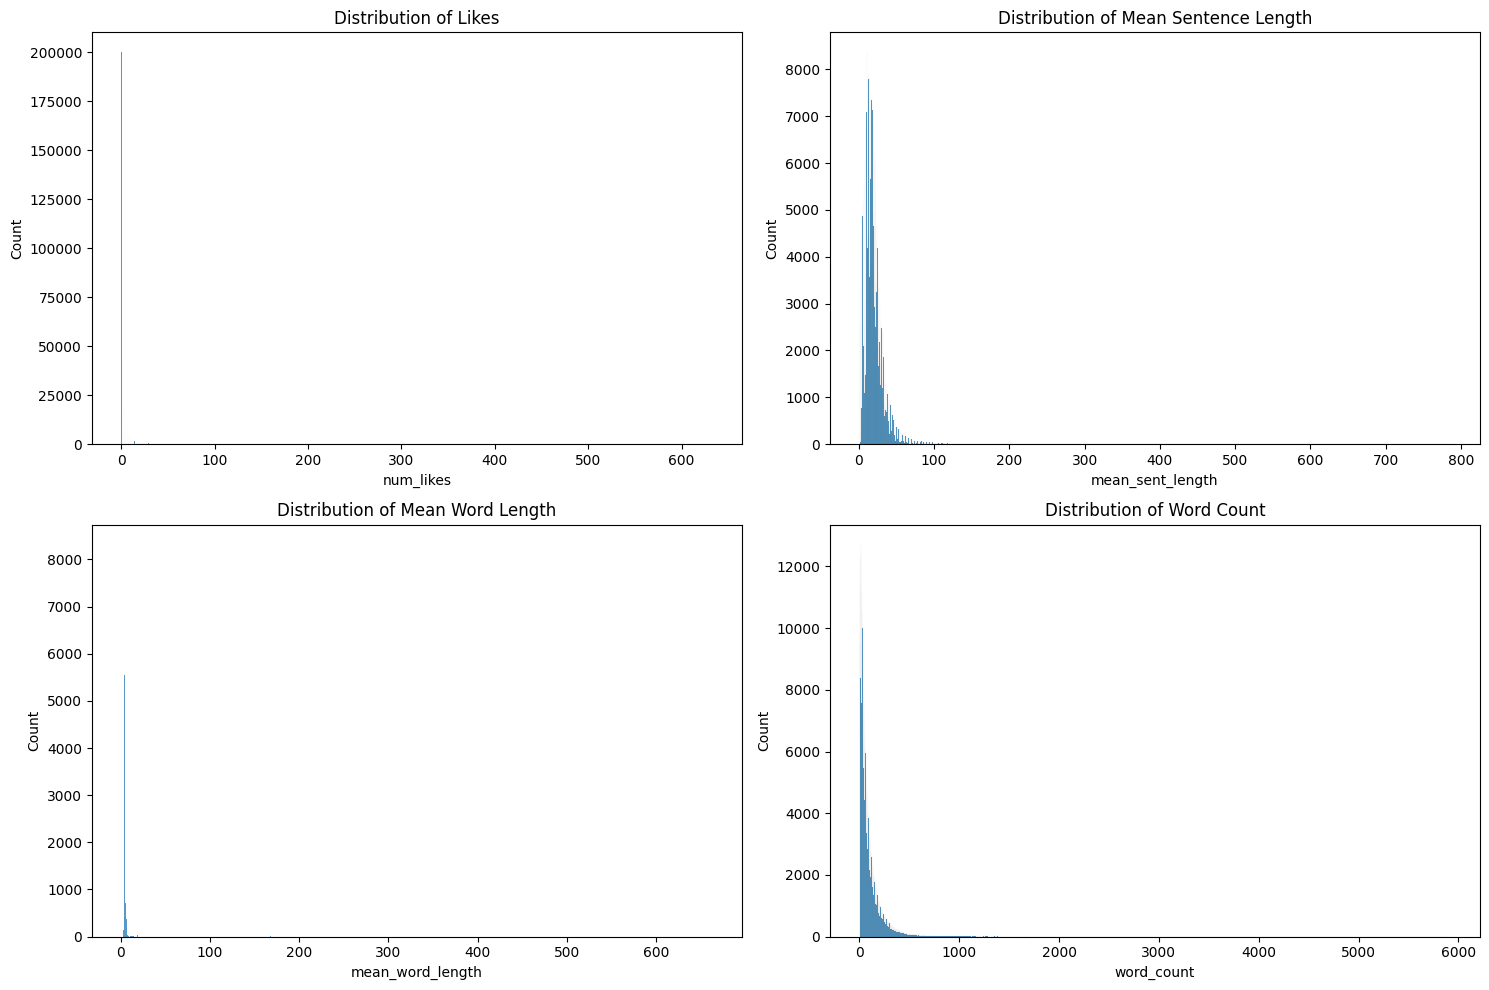

In [43]:
utils.descriptive_stats(df)

In [64]:
df.groupby(df['date'].dt.to_period("M"))['num_likes'].sum()

date
2005-08        2
2006-01       83
2006-02        8
2006-03       27
2006-04       40
           ...  
2023-06    17235
2023-07    16841
2023-08    16139
2023-09    14646
2023-10     6724
Freq: M, Name: num_likes, Length: 215, dtype: int64

### Time Series

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

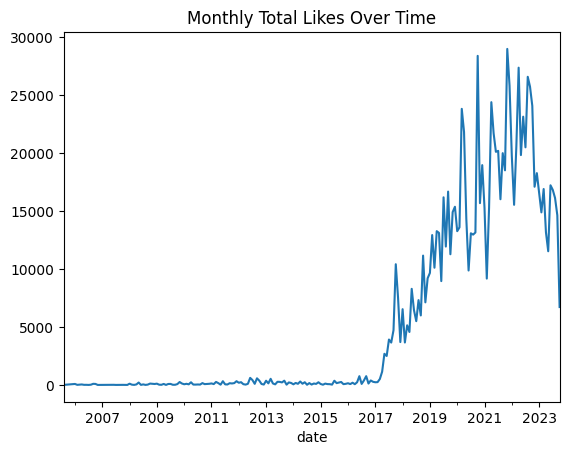

In [71]:
monthly_likes = df.groupby(df['date'].dt.to_period("M"))['num_likes'].sum()

monthly_likes.plot()
plt.title('Monthly Total Likes Over Time')
plt.show()

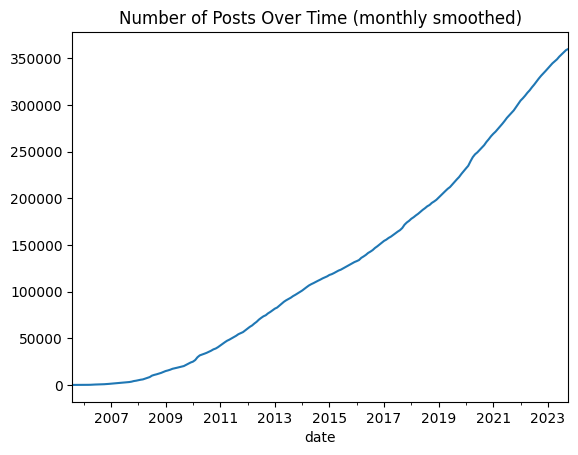

In [72]:
monthly_posts = df.groupby(df['date'].dt.to_period("M")).size()
monthly_posts.cumsum().plot()

plt.title('Number of Posts Over Time (monthly smoothed)')
plt.show()

In [82]:
top_locations

Index(['Unknown Hometown', 'OH', 'Boulder, CO', 'Boise, ID', 'Belgrade, MT',
       'Denver, CO', 'Upland', 'Portland, OR', 'Atascadero, CA',
       'Salt Lake City, UT', 'Golden, CO', 'Las Vegas, NV', 'Colorado',
       'Albuquerque, NM', 'Bishop, CA'],
      dtype='object', name='location')

### Categorical Analysis

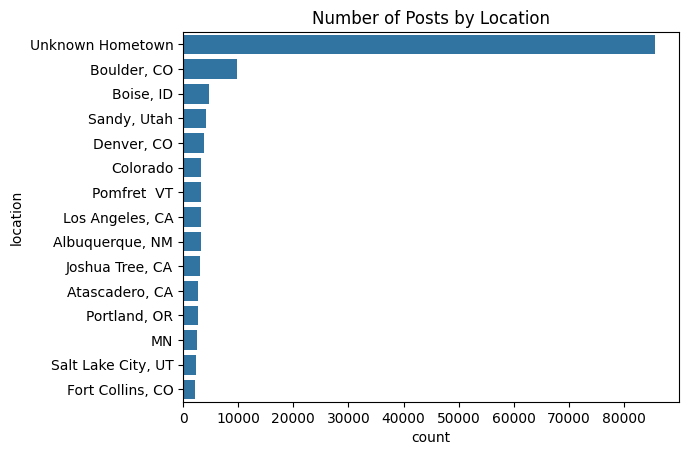

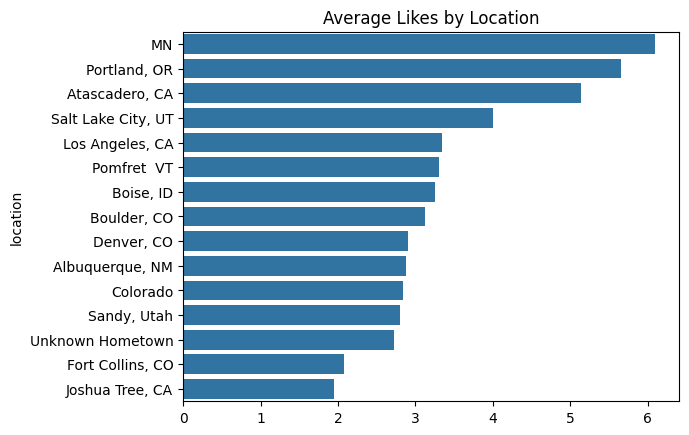

In [74]:
# Number of posts by location
col = 'location'
num = 15


top = df[col].value_counts().index[:num]
sns.countplot(y=df.loc[df.location.isin(top)].location, order=top)
plt.title('Number of Posts by Location')
plt.show()


# Average likes by location
top_locations = df[col].value_counts().head(num).index.tolist()
filtered_data = df[df[col].isin(top_locations)]
avg_likes = filtered_data.groupby(col)['num_likes'].mean()
sns.barplot(y=avg_likes.index, x=avg_likes.values, order=avg_likes.sort_values(ascending=False).index)
plt.title('Average Likes by Location')
plt.show()

### Textual Analysis

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform(df['body'])
top_words = vectorizer.get_feature_names_out()

print("Top 10 words:", top_words)

Top 10 words: ['climb' 'climbing' 'don' 'just' 'know' 'like' 'really' 'time' 've'
 'women']


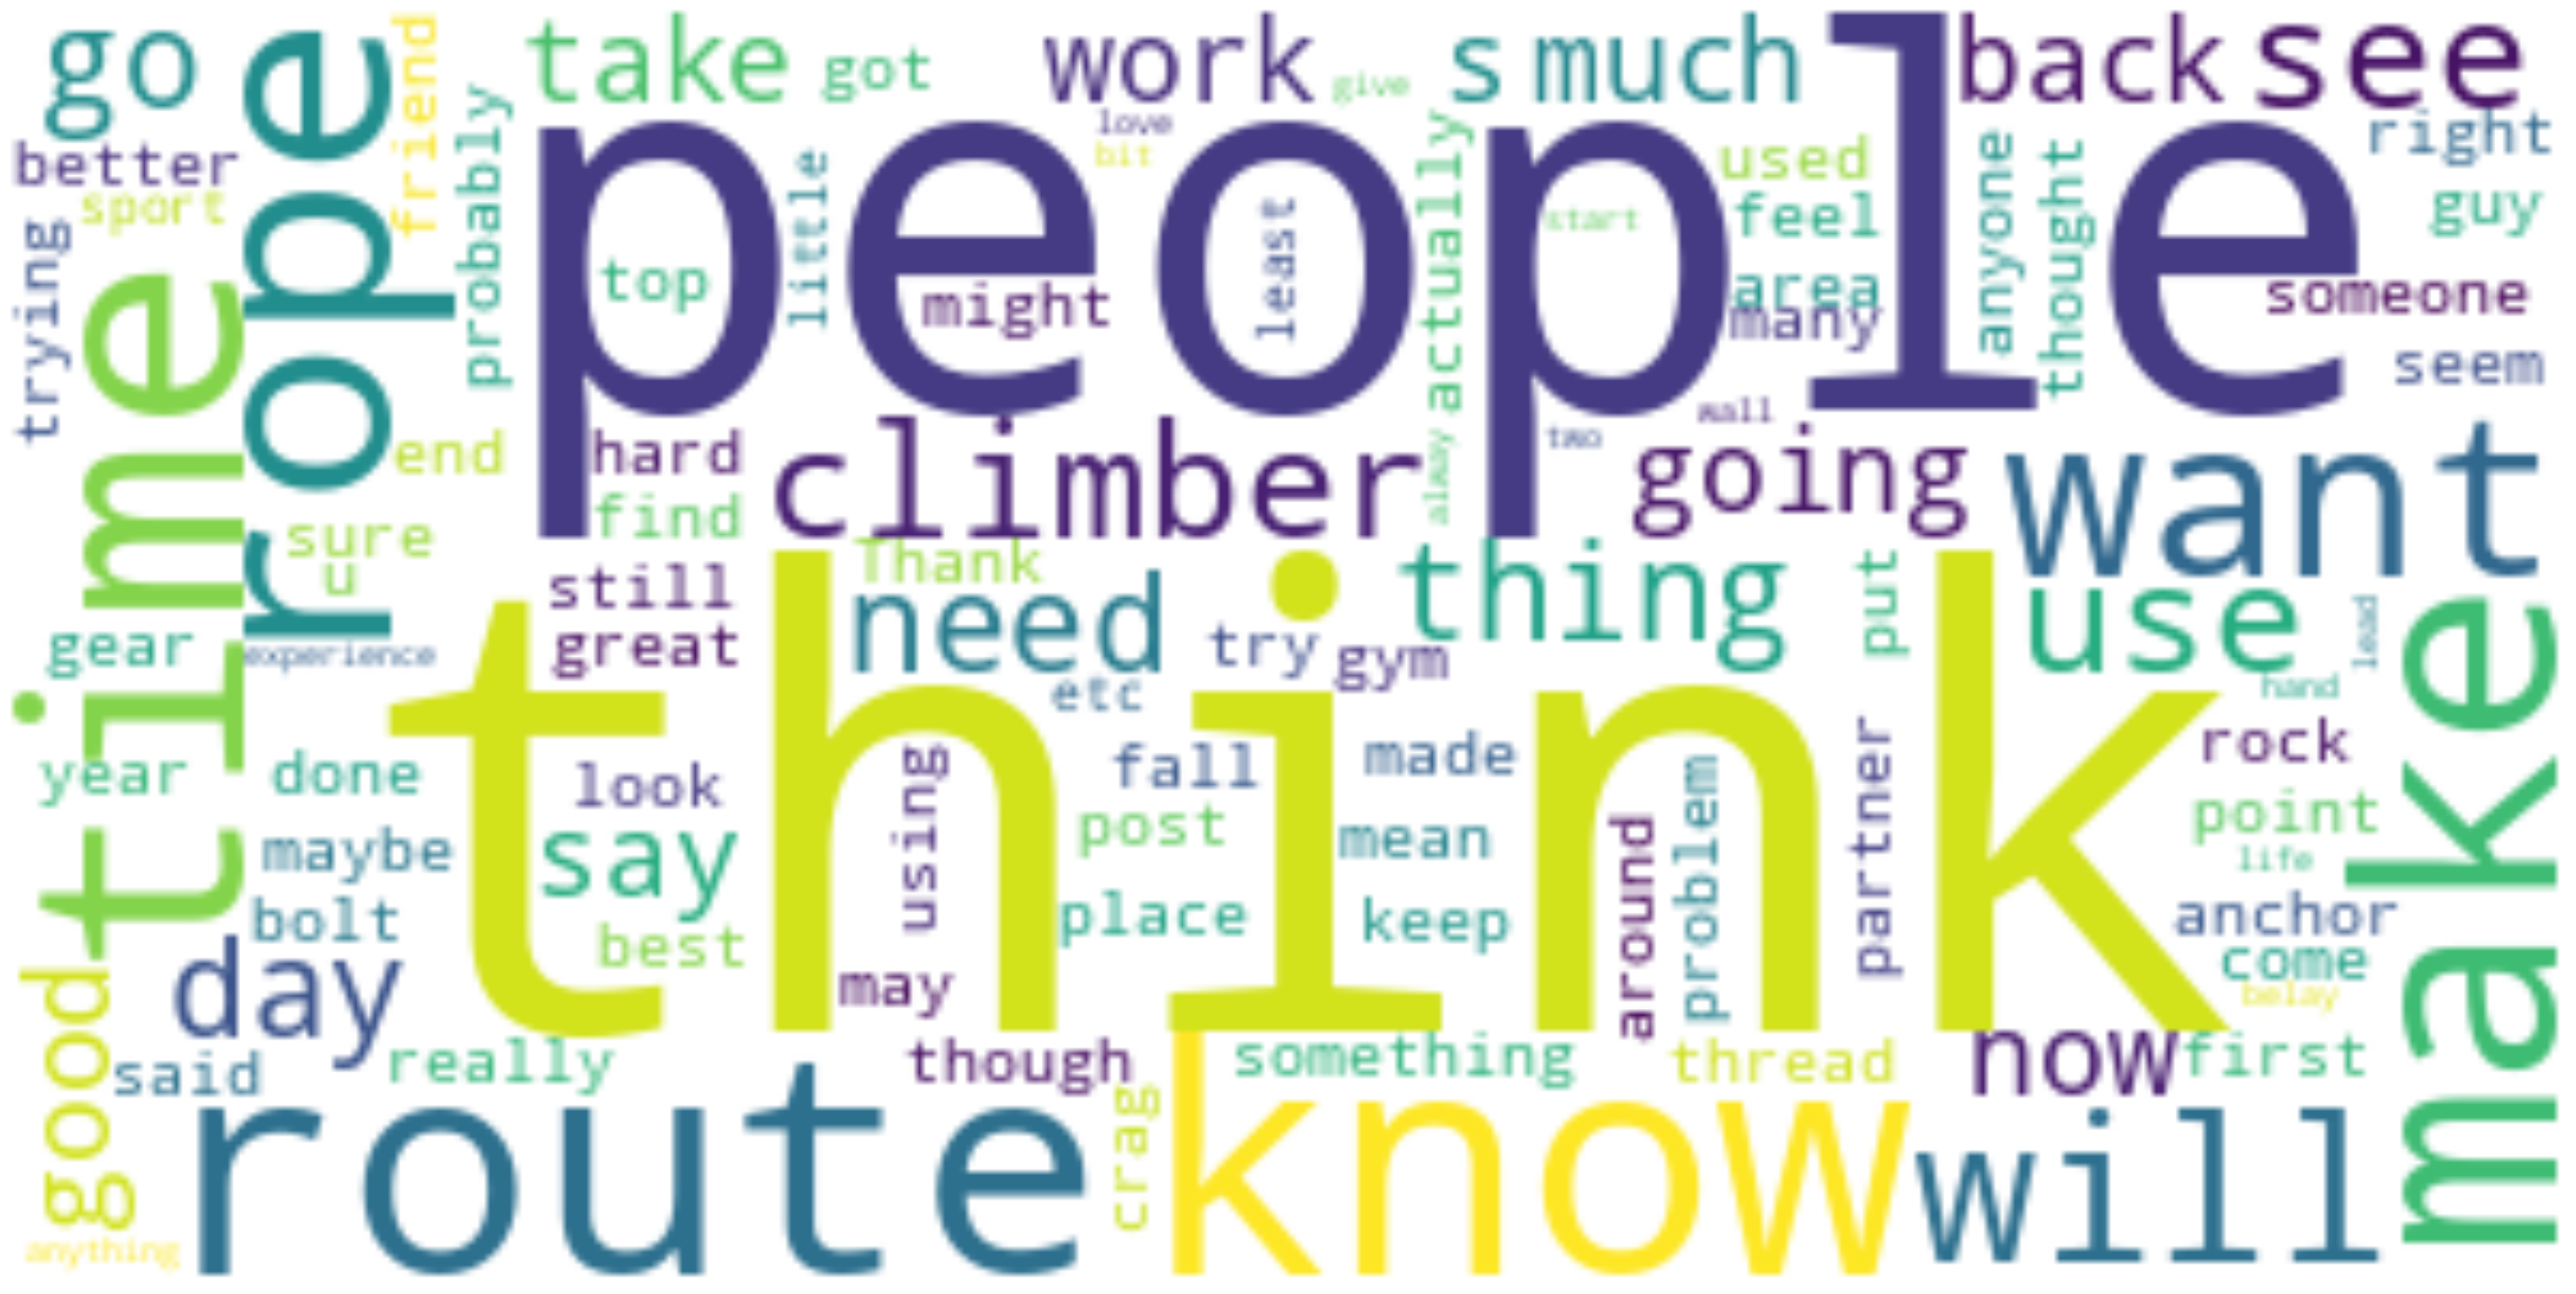

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from wordcloud import STOPWORDS

additional_stopwords = set(["m", "lot", "well", "way", "even", "climb", "climbing", "one", "word2", "word3"])  # Replace with any other words you deem as stop words
all_stopwords = STOPWORDS.union(additional_stopwords)

wordcloud = WordCloud(stopwords=all_stopwords, max_words=100, background_color="white").generate(" ".join(df['body']))

plt.figure(figsize=(50, 40))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


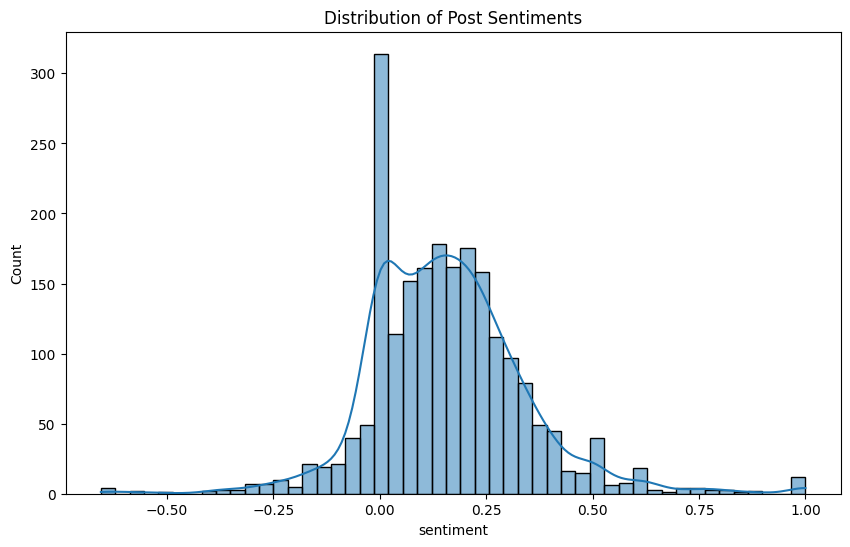

In [108]:
from textblob import TextBlob

df['sentiment'] = df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Distribution of sentiment
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Distribution of Post Sentiments')
plt.show()

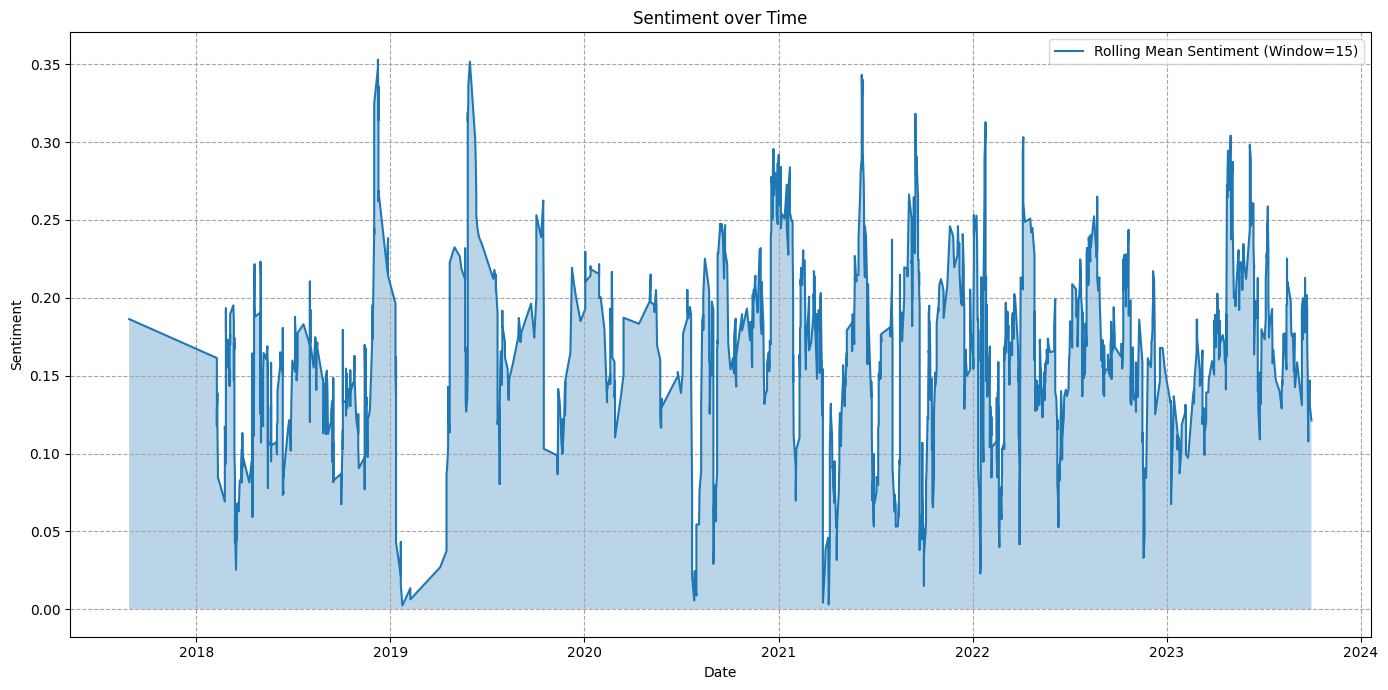

In [142]:
df = df.sort_values(by='date')
window_size = 15

roll = df['sentiment'].rolling(window=window_size).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['date'], roll, label=f'Rolling Mean Sentiment (Window={window_size})')
plt.fill_between(df['date'], roll, alpha=0.3)
plt.title('Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()

In [111]:
from sklearn.decomposition import LatentDirichletAllocation

# Using CountVectorizer with more features for LDA
vectorizer_lda = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
X_lda = vectorizer_lda.fit_transform(df['body'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lda)

# Displaying topics
def display_topics(model, feature_names, n_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
        print("\n")

display_topics(lda, vectorizer_lda.get_feature_names_out())

Topic 1:
climbing just like don climb time women think people know


Topic 2:
climbing climb looking love trad sport partners partner area hi


Topic 3:
women climbing wrote just shoes like people cold person forum


Topic 4:
use com https www water surgery using hands good long


Topic 5:
pants harness climbing size like fit gear women ve loops




In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df['body'])

lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=42)
lda_tfidf.fit(tfidf)

display_topics(lda_tfidf, tfidf_vectorizer.get_feature_names_out())

Topic 1:
climbing just women don like people think climb time wrote


Topic 2:
looking climbing climb love hi trad sport hey partner area


Topic 3:
com https wrote www forum cold bag helmet la jacket


Topic 4:
sent misty moving available bishop cadillac checking thanks mountain message


Topic 5:
pants harness size fit loops gear like good waist women




### Comparing Sentiment with Topic

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer_lda = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
X_lda = vectorizer_lda.fit_transform(df['body'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda.fit_transform(X_lda)


In [125]:
topic_map = ['general', 'partner_search', 'gear_recommendation', 'free_gear', 'sizing_recommendation']

In [126]:
df['dominant_topic'] = [topic_map[i] for i in lda_output.argmax(axis=1)]

In [118]:
df['sentiment'] = df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [127]:
average_sentiments = df.groupby('dominant_topic')['sentiment'].mean()

In [128]:
df.dominant_topic.value_counts()

dominant_topic
general                  671
partner_search           564
sizing_recommendation    431
gear_recommendation      294
free_gear                166
Name: count, dtype: int64

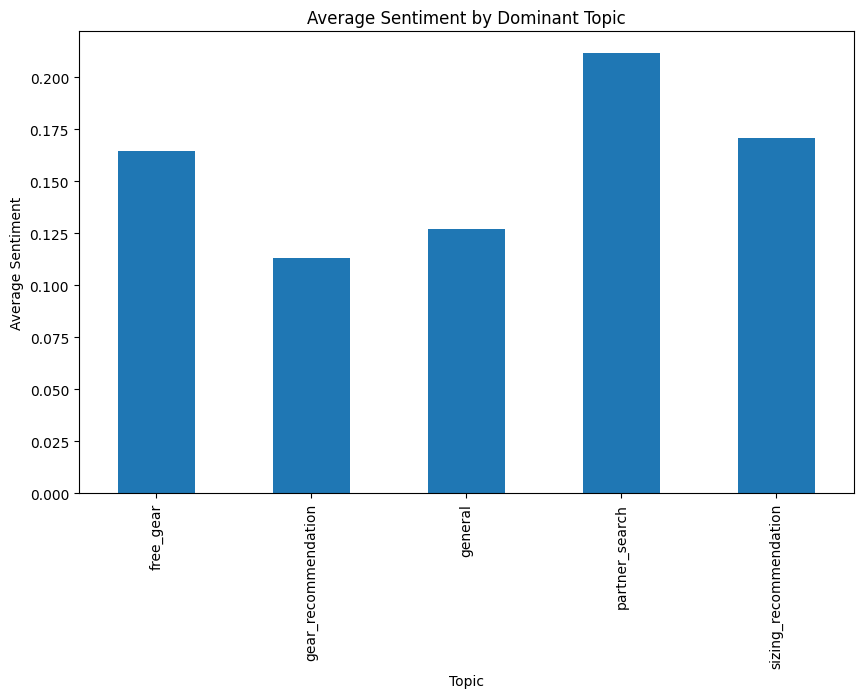

In [129]:
average_sentiments.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment by Dominant Topic')
plt.ylabel('Average Sentiment')
plt.xlabel('Topic')
plt.show()

In [147]:
df.columns

Index(['post_id', 'date', 'username', 'body', 'num_likes', 'location',
       'joined', 'points', 'mean_word_length', 'mean_sent_length',
       'word_count', 'sentiment', 'dominant_topic'],
      dtype='object')

# Getting Ratings (difficulty), Stars, and Ticks

## Getting Classic Routes at Red River Gorge

In [79]:
soup.find('div', class_='comment-list')

<div class="comment-list">
<img class="wait-gif mt-2" src="/img/waitWhite.gif"/>
</div>

In [71]:
def get_route_data(url):
    url = "https://www.mountainproject.com/route/105880926/eureka"
    page = urlopen(url).read()
    soup = BeautifulSoup(page)
    route_id = url.split('/')[-2]
    route_name = soup.find('h1').text.replace('\n', '').strip()
    route_grade = soup.find('span', class_='rateYDS').text
    ratings_data = soup.find('span', id="route-star-avg").text.replace('\n', '').strip().split(' ')
    avg_rating = float(ratings_data[1])
    num_ratings = int(ratings_data[3])

    # extract description
    desc_data = soup.find('table', class_='description-details')
    rows = desc_data.find_all('tr')[:3]
    climb_data = rows[0].find_all('td')[1].text.strip().split(', ')
    page_views = rows[2].find_all('td')[1].text.strip().replace('\n', '').replace('·', '').replace(' ', '').split('total')
    # extract type, height, naum_pitches, first ascenters, and page views (total / monthly)
    type_ = climb_data[0]
    height = climb_data[1]
    num_pitches = climb_data[2] if len(climb_data) == 3 else 1
    FA = rows[1].find_all('td')[1].text.strip()
    page_views_total = page_views[0]
    page_views_month = page_views[1].split('/')[0]


    route_comments = soup.find_all('span', class_='commentBody')
    route_comments = [comment.text for comment in route_comments]
    route_comments = ' '.join(route_comments)

    # return data as a dictionary
    return {'route_id': route_id, 'route_name': route_name, 
            'route_grade': route_grade, 'avg_rating': avg_rating, 
            'num_ratings': num_ratings, 'type': type_, 
            'height': height, 'num_pitches': num_pitches, 
            'FA': FA, 'page_views_total': page_views_total, 
            'page_views_month': page_views_month, 'route_comments': route_comments}

In [72]:
print(route_id, route_name, route_grade, avg_rating, num_ratings, type_, height, num_pitches, FA, page_views_total, page_views_month, route_comments, sep='\n')

105880926
Eureka
5.6 YDS
3.6
689
Sport
70 ft (21 m)
1
Scott Hammon and James Neukam, 1999
23,107
112



## Ticks (and other assorted data)
such as Ratings and Stars

In [11]:
import requests



# build the url
base_url = "https://www.mountainproject.com/api/v2/routes/"
data_types = ['stars', 'ratings', 'ticks']
# establish the headers
headers = {
  'Accept': '*/*',
  'Accept-Language': 'en-US,en;q=0.5',
  'Accept-Encoding': 'gzip, deflate, br',
  'Referer': 'https://www.mountainproject.com/route/stats/106657106/edge-a-sketch',
  'Alt-Used': 'www.mountainproject.com',
  'Connection': 'keep-alive',
  'Sec-Fetch-Dest': 'empty',
  'Sec-Fetch-Mode': 'cors',
  'Sec-Fetch-Site': 'same-origin',
  'Pragma': 'no-cache',
  'Cache-Control': 'no-cache',
  'TE': 'trailers',
  'Cookie': ''
}


routes = ["106657106"]
df_ticks = pd.DataFrame()
df_stars = pd.DataFrame()
df_ratings = pd.DataFrame()

for route in routes:
  for data_type in data_types:
    # iterate over the pages until data['data'] is empty and then stop
    data = []

    url = base_url + route + "/" + data_type + "?per_page=250&page="
    for i in range(1, 5):
        response = requests.request("GET", url+str(i), headers=headers, data={})
        data.extend(response.json()['data'])
        if len(response.json()['data']) == 0:
            break
      
    if data_type == 'ticks':
      new_df = pd.DataFrame(data)
      df_ticks = pd.concat([df_ticks, new_df])
    elif data_type == 'stars':
      new_df = pd.DataFrame(data)
      df_stars = pd.concat([df_stars, new_df])
    else:
      new_df = pd.DataFrame(data)
      df_ratings = pd.concat([df_ratings, new_df])

    # save the dataframes to a csv
    df_ticks.to_csv('data/ticks/ticks.csv', index=False)
    df_stars.to_csv('data/ticks/stars.csv', index=False)
    df_ratings.to_csv('data/ticks/ratings.csv', index=False)


In [10]:
df.groupby('type')

,id,date,comment,style,leadStyle,pitches,text,createdAt,updatedAt,user,type,route
0,125169608,"Oct 21, 2023, 12:00 am",None,Lead,Redpoint,1,&middot; Lead / Redpoint.,2023-10-21T12:34:31.000000Z,2023-10-21T12:34:31.000000Z,"{'id': 201556327, 'name': 'Elissa Frankel'}",ticks,106657106
1,125173612,"Oct 21, 2023, 12:00 am",None,TR,,1,&middot; TR. Lots of hangdog!,2023-10-21T22:41:07.000000Z,2023-10-21T22:41:07.000000Z,"{'id': 200504419, 'name': 'Charles Haase'}",ticks,106657106
2,125170882,"Oct 21, 2023, 12:00 am",None,TR,,1,&middot; TR. Bottom third is toughest part. ...,2023-10-21T18:02:15.000000Z,2023-10-21T18:02:15.000000Z,"{'id': 200147025, 'name': 'Chuck P'}",ticks,106657106
3,125149003,"Oct 17, 2023, 12:00 am",None,Lead,Fell/Hung,1,&middot; Lead / Fell/Hung. Hard boulder star...,2023-10-17T19:46:56.000000Z,2023-10-17T19:46:56.000000Z,"{'id': 200789830, 'name': 'Mariel Becker'}",ticks,106657106
4,125156885,"Oct 17, 2023, 12:00 am",None,Lead,Onsight,1,&middot; Lead / Onsight.,2023-10-19T01:10:42.000000Z,2023-10-19T01:10:42.000000Z,"{'id': 200279064, 'name': 'Benjamin Krakoff'}",ticks,106657106
...,...,...,...,...,...,...,...,...,...,...,...,...
903,124853160,"Sep 1, 2006, 12:00 am",None,Lead,Onsight,1,&middot; Lead / Onsight.,2023-09-01T22:33:01.000000Z,2023-09-01T22:33:01.000000Z,"{'id': 201079240, 'name': 'John Aragon'}",ticks,106657106
904,111681251,"Nov 3, 2005, 12:00 am",None,Lead,Onsight,1,&middot; Lead / Onsight.,2005-11-03T00:00:00.000000Z,2005-11-03T00:00:00.000000Z,"{'id': 111674806, 'name': 'Merrick Schaefer'}",ticks,106657106
905,107204389,"Jun 5, 2005, 12:00 am",None,,,1,,2005-06-05T00:00:00.000000Z,2005-06-05T00:00:00.000000Z,"{'id': 107172119, 'name': 'Phil'}",ticks,106657106
906,110010398,"Dec 31, 1969, 5:00 pm",None,,,1,,1970-01-01T00:00:00.000000Z,1970-01-01T00:00:00.000000Z,False,ticks,106657106


In [41]:
df

,id,score,createdAt,updatedAt,user,dtype
0,830949,5,2017-10-05T18:05:50.000000Z,2017-10-05T18:05:50.000000Z,"{'id': 106610639, 'name': 'Zach Wahrer'}",stars
1,850536,5,2017-10-05T18:06:24.000000Z,2017-10-05T18:06:24.000000Z,"{'id': 107898981, 'name': 'Matt Wrodarczyk'}",stars
2,1055573,5,2017-10-05T18:15:52.000000Z,2017-10-05T18:15:52.000000Z,"{'id': 106449553, 'name': 'Tom Caldwell'}",stars
3,1062707,5,2017-10-05T18:16:15.000000Z,2017-10-05T18:16:15.000000Z,"{'id': 106893421, 'name': 'NickinCO'}",stars
4,1135495,5,2017-10-05T18:20:10.000000Z,2017-10-05T18:20:10.000000Z,"{'id': 106812235, 'name': 'Ray Bierbaum'}",stars
...,...,...,...,...,...,...
285,59285622,3,2022-11-14T20:48:44.000000Z,2022-11-14T20:48:44.000000Z,"{'id': 201332130, 'name': 'David Wirth'}",stars
286,67257277,3,2023-05-22T16:31:40.000000Z,2023-05-22T16:31:40.000000Z,"{'id': 200866154, 'name': 'Vince Guerino'}",stars
287,71066437,3,2023-07-30T17:22:30.000000Z,2023-07-30T17:22:30.000000Z,"{'id': 107469550, 'name': 'Mike Robinson'}",stars
288,1354911,2,2017-10-05T18:31:59.000000Z,2017-10-05T18:31:59.000000Z,"{'id': 107633023, 'name': 'David Cooper'}",stars
